Я решила взять датасет с Kaggle, который подходит под задачу классификации текста: [Sentiment Analysis Evaluation Dataset](https://www.kaggle.com/datasets/prishasawhney/sentiment-analysis-evaluation-dataset)

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prishasawhney/sentiment-analysis-evaluation-dataset")

print("Path to dataset files:", path)

100%|██████████| 7.77k/7.77k [00:00<00:00, 4.68MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/prishasawhney/sentiment-analysis-evaluation-dataset/versions/1


In [2]:
import os
import warnings
from collections import Counter
from typing import Iterable, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.distributions.categorical import Categorical
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from transformers import BertTokenizerFast

warnings.filterwarnings("ignore")

In [3]:
os.listdir(path)

['Finance.csv', 'Politics.csv', 'Education.csv', 'Sports.csv']

In [4]:
df_education = pd.read_csv(f'{path}/Education.csv')
df_finance = pd.read_csv(f'{path}/Finance.csv')
df_politics = pd.read_csv(f'{path}/Politics.csv')
df_sports = pd.read_csv(f'{path}/Sports.csv')

df = pd.concat([df_education, df_finance, df_politics, df_sports], ignore_index=True)
df.head()

,Text,Label
0,The impact of educational reforms remains unce...,positive
1,Critics argue that recent improvements in the ...,negative
2,Innovative teaching methods have led to unexpe...,positive
3,"Despite budget constraints, the school has man...",positive
4,The true effectiveness of online learning plat...,negative


In [5]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
df['Text_length'] = df['Text'].apply(lambda x: len(x))
df.sort_values(by=['Text_length'], ascending=False)

,Text,Label,Text_length
98,Financial institutions play a pivotal role in ...,1,118
95,Financial markets play a crucial role in alloc...,1,117
82,The principles of diversification and asset al...,1,116
97,The use of leverage in financial markets ampli...,0,114
92,The regulatory environment for financial servi...,1,114
...,...,...,...
161,Sportsmanship and fair play are essential valu...,1,62
160,Team sports encourage collaboration and commun...,1,61
168,The impact of sports on society is complex and...,1,60
154,"Despite their recent loss, the team's morale r...",1,58


In [6]:
df.shape

(209, 3)

In [174]:
df['Label'].value_counts()

,count
Label,
1,113
0,96


In [18]:
class SentimentDataset(Dataset):
    def __init__(self, input_ids, labels, lengths):
        self.input_ids = input_ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, item):
        return {
            'input_ids': self.input_ids[item],
            'labels': torch.tensor(self.labels[item], dtype=torch.long),
            'lengths': self.lengths[item]
        }

def tokenize_texts(tokenizer, texts, max_length):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    lengths = [min(len(text.split()), max_length) for text in texts]
    return encodings, lengths

https://huggingface.co/docs/transformers/model_doc/bert

In [19]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [133]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'], df['Label'], test_size=0.15, random_state=42)
seq_len = df['Text_length'].max()

train_encodings, train_lengths = tokenize_texts(tokenizer, train_texts, max_length=seq_len)
val_encodings, val_lengths = tokenize_texts(tokenizer, val_texts, max_length=seq_len)

train_dataset = SentimentDataset(train_encodings['input_ids'], train_labels.tolist(), train_lengths)
val_dataset = SentimentDataset(val_encodings['input_ids'], val_labels.tolist(), val_lengths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [134]:
for batch in val_loader:
    print(batch['input_ids'].shape)
    print(batch['labels'].shape)
    print(batch['lengths'].shape)
    print("Tokens (1st text):", batch['input_ids'][0][:10])
    print("Label:", batch['labels'][0])
    print("Length:", batch['lengths'][0])
    print(val_texts.iloc[0])
    break

torch.Size([16, 118])
torch.Size([16])
torch.Size([16])
Tokens (1st text): tensor([ 101, 2495, 6043, 2323, 2022, 6727, 2011, 2470, 1998, 2190])
Label: tensor(1)
Length: tensor(10)
Education policies should be informed by research and best practices.


In [234]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, drop_rate=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(drop_rate)

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

    def forward(self, input_ids, lengths):
        batch_size = input_ids.size(0)
        hidden = self.init_hidden(batch_size)
        embedded = self.embedding(input_ids)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        _, (hidden_state, cell_state) = self.lstm(packed, hidden)
        output = self.fc(self.dropout(hidden_state[-1]))
        output = torch.sigmoid(output)
        return output

    def inference(self, input_ids, lengths):
        self.eval()
        batch_size = input_ids.size(0)
        hidden = self.init_hidden(batch_size)
        embedded = self.embedding(input_ids)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        _, (hidden_state, cell_state) = self.lstm(packed, hidden)
        output = self.fc(hidden_state[-1])
        output = torch.sigmoid(output)
        return output

In [235]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=100, patience=20, save_path='rnn.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, batch['lengths'])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = train_correct / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, batch['lengths'])
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = val_correct / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch}/{num_epochs}: Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), f'best_{save_path}')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [236]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.show()

In [237]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Epoch 1/100: Train Loss: 0.6903, Train Acc: 0.5593, Val Loss: 0.6940, Val Acc: 0.4375
Epoch 2/100: Train Loss: 0.6914, Train Acc: 0.5650, Val Loss: 0.6940, Val Acc: 0.4375
Epoch 3/100: Train Loss: 0.6909, Train Acc: 0.5593, Val Loss: 0.6937, Val Acc: 0.4375
Epoch 4/100: Train Loss: 0.6864, Train Acc: 0.5650, Val Loss: 0.6931, Val Acc: 0.4375
Epoch 5/100: Train Loss: 0.6844, Train Acc: 0.5650, Val Loss: 0.6929, Val Acc: 0.4375
Epoch 6/100: Train Loss: 0.6817, Train Acc: 0.5763, Val Loss: 0.6925, Val Acc: 0.4375
Epoch 7/100: Train Loss: 0.6856, Train Acc: 0.5650, Val Loss: 0.6919, Val Acc: 0.4688
Epoch 8/100: Train Loss: 0.6831, Train Acc: 0.5763, Val Loss: 0.6897, Val Acc: 0.4688
Epoch 9/100: Train Loss: 0.6712, Train Acc: 0.6102, Val Loss: 0.6866, Val Acc: 0.4688
Epoch 10/100: Train Loss: 0.6524, Train Acc: 0.6158, Val Loss: 0.6821, Val Acc: 0.4688
Epoch 11/100: Train Loss: 0.6208, Train Acc: 0.6441, Val Loss: 0.6751, Val Acc: 0.5000
Epoch 12/100: Train Loss: 0.6045, Train Acc: 0.6723,

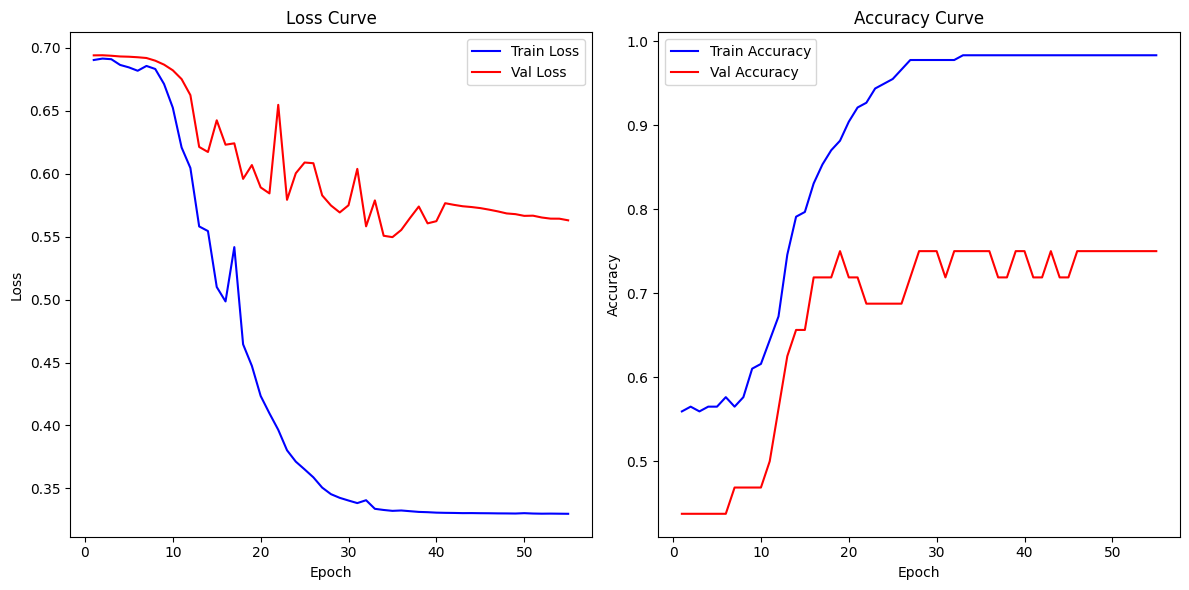

In [255]:
num_classes = len(set(df['Label']))

model = RNNClassifier(vocab_size=tokenizer.vocab_size, embedding_dim=100, hidden_dim=256, output_dim=num_classes,
                      num_layers=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, criterion, num_epochs=100, patience=20, save_path='rnn.pth'
)

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

In [259]:
model.load_state_dict(torch.load('best_rnn.pth'))
model.to(device)

def infer_with_inference_method(model, text, tokenizer, max_length=512):
    encoding, lengths = tokenize_texts(tokenizer, pd.Series(text), max_length=max_length)
    input_ids = encoding['input_ids'].to(device)

    prediction = model.inference(input_ids, lengths)
    predicted_class = torch.argmax(prediction, dim=-1)
    return prediction.cpu().detach().numpy()[0], predicted_class

text1 = "I love programming in Python, it is amazing programming language"
text2 = "I hate Python"
prediction1, predicted_class1 = infer_with_inference_method(model, text1, tokenizer, seq_len)
prediction2, predicted_class2 = infer_with_inference_method(model, text2, tokenizer, seq_len)

print(f"Text 1 '{text1}'\n",
      f"Predicted probs: {prediction1}\n",
      f"Predicted sentiment: {label_encoder.classes_[predicted_class1]}\n")

print(f"Text 2 '{text2}'\n",
      f"Predicted probs: {prediction2}\n",
      f"Predicted sentiment: {label_encoder.classes_[predicted_class2]}")

Text 1 'I love programming in Python, it is amazing programming language'
 Predicted probs: [0.03654233 0.96252495]
 Predicted sentiment: positive

Text 2 'I hate Python'
 Predicted probs: [0.7006198 0.3045537]
 Predicted sentiment: negative
